In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.metrics import roc_auc_score
# import riiideducation
# from tqdm import tqdm

In [2]:
# 한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

[Riiid Answer Correctness Prediction 링크](https://www.kaggle.com/c/riiid-test-answer-prediction)

In [4]:
'''
question == 문제
tag = 해설지(코드)
tags = 비슷한 것 끼리 묶은 것들

train.csv

row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. 
For example, a user might see three questions in a row before seeing the explanations for any of them. 
Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question 
in the previous question bundle, ignoring any lectures in between. 
Is null for a user's first question bundle or lecture. 
Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) 
after answering the previous question bundle, ignoring any lectures in between. 
The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. 
Typically the first several questions a user sees were part of an onboarding diagnostic test 
where they did not get any feedback.



questions.csv: metadata for the questions posed to users.

question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: the relevant section of the TOEIC test.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.



lectures.csv: metadata for the lectures watched by users as they progress in their education.

lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).

part: top level category code for the lecture.

tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

type_of: brief description of the core purpose of the lecture



example_test_rows.csv Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

prior_group_responses (string) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

prior_group_answers_correct (string) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.
'''

"\nquestion == 문제\ntag = 해설지(코드)\ntags = 비슷한 것 끼리 묶은 것들\n\ntrain.csv\n\nrow_id: (int64) ID code for the row.\n\ntimestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.\n\nuser_id: (int32) ID code for the user.\n\ncontent_id: (int16) ID code for the user interaction\n\ncontent_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.\n\ntask_container_id: (int16) Id code for the batch of questions or lectures. \nFor example, a user might see three questions in a row before seeing the explanations for any of them. \nThose three would all share a task_container_id.\n\nuser_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.\n\nanswered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.\n\nprior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question 

In [5]:
train = pd.read_csv('F:/data/riiid-test-answer-prediction/train.csv', nrows=10**4)
test = pd.read_csv("F:/data/riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("F:/data/riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("F:/data/riiid-test-answer-prediction/questions.csv")

In [6]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
9995,9995,2868187305,91216,1124,0,775,0,0,18000.0,True
9996,9996,2868272689,91216,810,0,776,0,1,18000.0,True
9997,9997,2868367298,91216,1245,0,777,0,1,17000.0,True
9998,9998,2868439137,91216,711,0,778,3,1,17000.0,True


---

In [7]:
# 우리가 시도한 것
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     9742 non-null   float64
 9   prior_question_had_explanation  9979 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [8]:
train.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')

In [233]:
# timestamp : 수강권을 끊은 유저가 강의를 본 시간이나 문제를 푼 총 시간??
# train[train.user_id == 91216][:30]

In [10]:
train.user_id.unique()

array([  115,   124,  2746,  5382,  8623,  8701, 12741, 13134, 24418,
       24600, 32421, 40828, 44331, 45001, 46886, 50132, 51285, 53842,
       81002, 81429, 91216], dtype=int64)

In [11]:
train.user_id.nunique()

21

In [12]:
# content_id = lecture_id + question_id
train.content_id.unique()

array([ 5692,  5716,   128, ..., 26335,  8848,  1244], dtype=int64)

In [13]:
# 21명이 총 6576개의 lecture랑 question를 보았다.
train.content_id.nunique()

6576

In [14]:
# 0이면 바로 문제푼거고, 1이면 강의를 본거고
train.content_type_id.value_counts()

0    9763
1     237
Name: content_type_id, dtype: int64

In [15]:
'''
task_container_id 설명

task_container_id: (int16) Id code for the batch of questions or lectures. => id code다 무엇을 위한? 배치인데 문제들이나 강의들에 대한
For example, a user might see three questions in a row before seeing the explanations for any of them. => 예를 들어 한 유저가 연속적인 3 문제를 볼거야 / 그거이 어떤 것이든 문제의 해설지를 보기 전에
Those three would all share a task_container_id. => 이러한 3개 문제들은 하나의 task_container_id를 공유해

task_container_id는 문제 타입 유형의 갯수 (누적)


문제가 나왔다.

sum=0
if 강의 봤어
sum+=1
task_cont.append[sum]
elif 강의 안 보고 문제만 풀었어 
sum+=1


틀렸어. 그 문제 유형이 사역동사. 묻는 문제
계속 틀려. => 산타토익 추천 => 사역동사 관련 강의 볼래? => 1 (강의 봤어) => ok => 사역동사 관련 강의 (7900) => 그 문제 유형을 다시 푼다. => 얘는 강의를 봤네? 산타토익은 본거 체크 0->1(task_container_id)
계속 틀려 => 산토팅ㄱ 추천 => 안보고 계속 풀어 => 0 (강의 안봤어)

 계속 틀려 => 산타토익 추천 => be동사 관련 강의(cotnent_id) 볼래? 아니 안 볼래 = > 0(content_type_id) => 강의 안보고도 문제 푸는 거 => 이 문제 유형을 풀었네 1->2 (task_container_id)


ex)
사역동사 : 7900
be동사 : 7876
5형식 동사 : 175 
'''

'\ntask_container_id 설명\n\ntask_container_id: (int16) Id code for the batch of questions or lectures. => id code다 무엇을 위한? 배치인데 문제들이나 강의들에 대한\nFor example, a user might see three questions in a row before seeing the explanations for any of them. => 예를 들어 한 유저가 연속적인 3 문제를 볼거야 / 그거이 어떤 것이든 문제의 해설지를 보기 전에\nThose three would all share a task_container_id. => 이러한 3개 문제들은 하나의 task_container_id를 공유해\n\ntask_container_id는 문제 타입 유형의 갯수 (누적)\n\n\n문제가 나왔다.\n\nsum=0\nif 강의 봤어\nsum+=1\ntask_cont.append[sum]\nelif 강의 안 보고 문제만 풀었어 \nsum+=1\n\n\n틀렸어. 그 문제 유형이 사역동사. 묻는 문제\n계속 틀려. => 산타토익 추천 => 사역동사 관련 강의 볼래? => 1 (강의 봤어) => ok => 사역동사 관련 강의 (7900) => 그 문제 유형을 다시 푼다. => 얘는 강의를 봤네? 산타토익은 본거 체크 0->1(task_container_id)\n계속 틀려 => 산토팅ㄱ 추천 => 안보고 계속 풀어 => 0 (강의 안봤어)\n\n 계속 틀려 => 산타토익 추천 => be동사 관련 강의(cotnent_id) 볼래? 아니 안 볼래 = > 0(content_type_id) => 강의 안보고도 문제 푸는 거 => 이 문제 유형을 풀었네 1->2 (task_container_id)\n\n\nex)\n사역동사 : 7900\nbe동사 : 7876\n5형식 동사 : 175 \n'

In [16]:
train[train.user_id == 124]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
46,46,0,124,7900,0,0,0,1,NaN,NaN
47,47,32683,124,7876,0,1,0,0,26000.0,False
48,48,62000,124,175,0,2,2,1,29000.0,False
49,49,83632,124,1278,0,3,1,0,26000.0,False
50,50,189483,124,2064,0,4,2,0,18000.0,False
51,51,189483,124,2063,0,4,3,0,18000.0,False
52,52,189483,124,2065,0,4,2,1,18000.0,False
53,53,258793,124,3364,0,5,2,0,33333.0,False
54,54,258793,124,3365,0,5,3,0,33333.0,False
55,55,258793,124,3363,0,5,0,0,33333.0,False


In [17]:
# 보기는 0,1,2,3 인데 -1은 강의를 본 것
train.user_answer.unique()

array([ 3,  2,  0,  1, -1], dtype=int64)

In [18]:
train.user_answer.value_counts()

 0    2719
 1    2715
 3    2602
 2    1727
-1     237
Name: user_answer, dtype: int64

In [19]:
# 1은 정답을 맞힌 것, 0은 오답을 낸 것, -1은 강의를 본 것 
train.answered_correctly.value_counts()

 1    6578
 0    3185
-1     237
Name: answered_correctly, dtype: int64

In [20]:
# 이전에 문제를 푼 경과 시간. 만약에 문제가 세트로 나오면 그 문제들의 평균 시간
train.prior_question_elapsed_time

0           NaN
1       37000.0
2       55000.0
3       19000.0
4       11000.0
         ...   
9995    18000.0
9996    18000.0
9997    17000.0
9998    17000.0
9999    16000.0
Name: prior_question_elapsed_time, Length: 10000, dtype: float64

In [21]:
# 이전의 문제 묶음을 푼 후, 해설지나 정답을 봤으면 True, 어떤 경우에든 안 봤으면 False
train.prior_question_had_explanation.value_counts()

True     9330
False     649
Name: prior_question_had_explanation, dtype: int64

---

In [ ]:
'''
관계 시각화 정리

train.colummns : Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')
	  
1. train - timestamp / 각각 유저의 일수
2. train - content_id / 갯수
3. train - user_answer / 유저가 선택한 정답 비율
4. train - answer_correctly / 유저가 실제로 맞은 수 (1,0)
5. train - user_percent(새로 만듦) / 유저가 문제푼 수와 실제 맞은 비율 간의 관계
6. train - prior_question_elapsed_time / 하나 푸는 데 걸리는 평균 시간(초)
7. train - prior_question_had_explanation / 해설지보고 맞은 비율
8. train - user_id,answered_correctly / 강의시청 유무별 정답률 



questions.columns : Index(['question_id', 'bundle_id', 'correct_answer', 'part', 'tags'], dtype='object')

1. question - tags_select / 어려운태그, 쉬운태그 탑 10
2. question - tags_select / 태그당 사용된 횟수
3. question - question_id / 파트별 문제수
4. question - question_id / 문제의 파트 비율
5. question - question_id / 파트별 문제수
6. question- part 파트당 정답률



lectures.columns : Index(['lecture_id', 'tag', 'part', 'type_of'], dtype='object')

1. lecture - type_of,lecture_id / 강의 파트별 갯수

1. train_lecture - part,lecture_id / 학생들이 파트별 시청한 강의 수, 파트별 전체 강의 수
2. train_lecture - task_container_id, user_id / 학생들이 task_container_id의 20개 구간별 시청한 강의 수
3. train_lecture - task_container_id, user_id / task_container_id 의 최댓값별 학생
'''

# 우리가 이번 프로젝트에서 한 것 : EDA 기초분석(데이터가 무엇인지, 무엇에 포커스를 맞춰야 하는지 보기 위해) / 전처리(모델에 적합한 데이터 형식을 만들기 위해)
# => 하나하나 문제 맞추는 거 예측 => 전체 토익 200문제 => 점수 예상  

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     9742 non-null   float64
 9   prior_question_had_explanation  9979 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [23]:
# 코드 이해
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

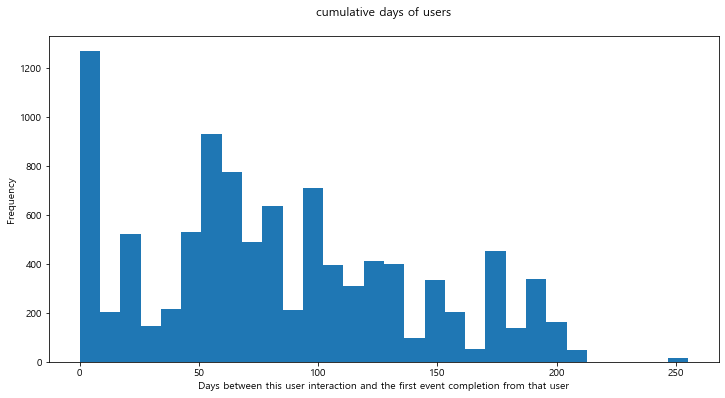

In [24]:
#1 year = 31536000000 ms
# 1s = 1000ms
# 1ms = 1/1000 s
# 60s = 1 min
# 60 min = 1 hr
# 1 day = 24hr
# 1 month = 30 * 24 * 60 * 60 * 1000 ms
# 1 year = 365 day = 365 * 24 hr 
# 1 year = 365 * 24 * 30 * 60 * 60 * 1000 ms
ts = train['timestamp']/(24 * 60 * 60 * 1000) # timestamp가 ms 단위인데 day로 환산
plt.figure(figsize=(12,6))
ts.plot.hist(bins=30)
plt.title('cumulative days of users', pad=20)
plt.xlabel('Days between this user interaction and the first event completion from that user')

plt.show()

# 해야 될 것 : 각각 사용자의 일수를 가져오는 전처리 작업 필요 


In [25]:
train.user_id.nunique()

21

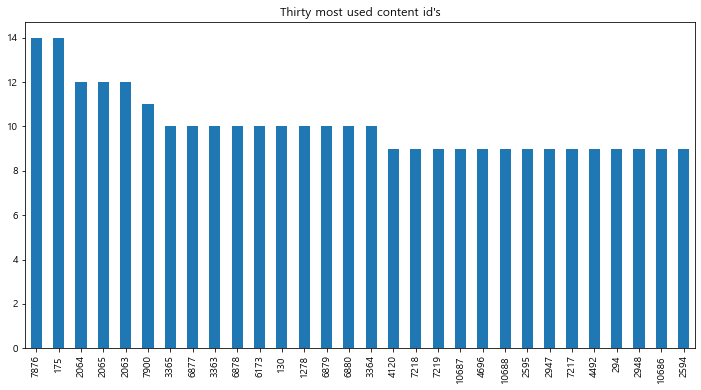

In [26]:
cids = train.content_id.value_counts()[:30]

plt.figure(figsize=(12,6))
cids.plot.bar()
plt.title("Thirty most used content id's")

# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))s
plt.show()

In [27]:
train.content_type_id.value_counts()

0    9763
1     237
Name: content_type_id, dtype: int64

<AxesSubplot:ylabel='user_answer'>

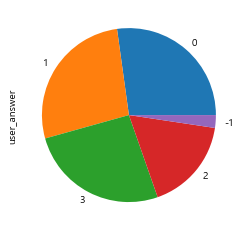

In [28]:
user_answer = train.user_answer.value_counts()
user_answer.plot.pie()
# 수정 필요 (수치라던가, 제목이라던가)

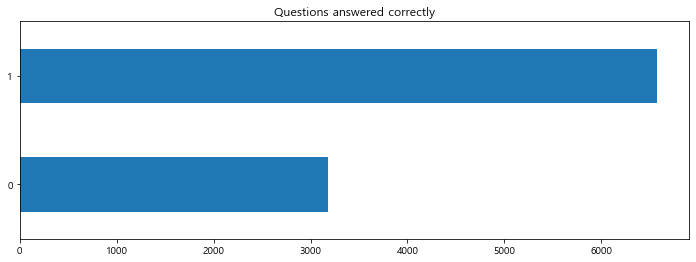

In [29]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

plt.figure(figsize=(12,4))
correct.plot.barh()
# for i, v in zip(correct.index, correct.values):
    # plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.show()

In [30]:
train[train.answered_correctly != -1].groupby('answered_correctly').size()
# train.pivot()

answered_correctly
0    3185
1    6578
dtype: int64

In [31]:
user_percent = train[train.answered_correctly != -1].groupby('user_id').answered_correctly.agg(Mean='mean', Answers='count')

In [32]:
user_percent[:15]

,Mean,Answers
user_id,,
115,0.695652,46
124,0.233333,30
2746,0.578947,19
5382,0.672000,125
8623,0.642202,109
8701,0.588235,17
12741,0.573585,265
13134,0.706356,1243
24418,0.690275,6283


In [33]:
user_percent.Answers.max()

6283

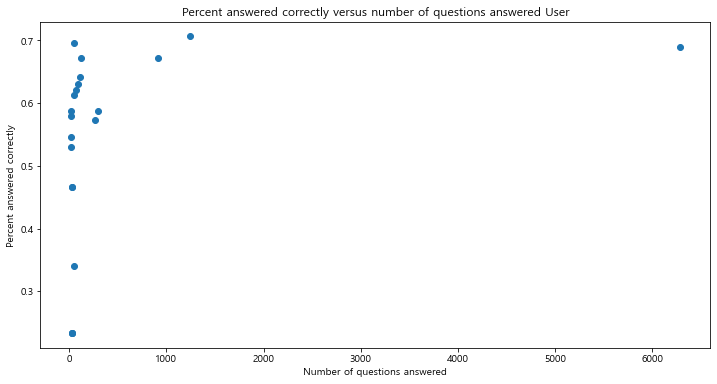

In [34]:
plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

#  = np.polyfit(x, y, 1)
#  = np.poly1d(z)
# lt.plot(x,p(x),"r--")
plt.show()

In [35]:
content_percent = train[train.answered_correctly != -1].groupby('content_id').answered_correctly.agg(Mean='mean', Answers='count')

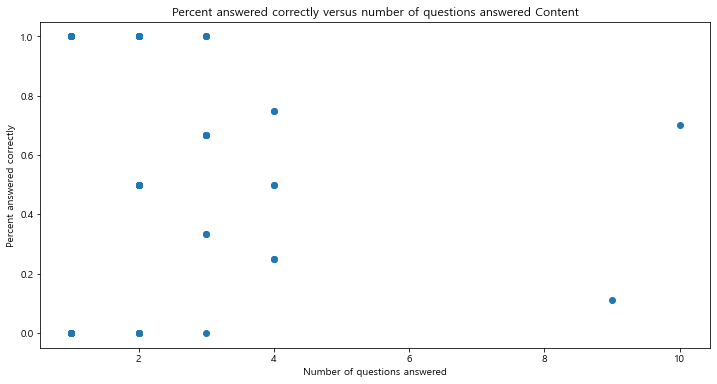

In [36]:
# ??
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1) # 이해 필요

plt.figure(figsize=(12,6))
x1 = content_percent.Answers
y1 = content_percent.Mean
plt.scatter(x1, y1, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content")
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

#  = np.polyfit(x, y, 1)
#  = np.poly1d(z)
# lt.plot(x,p(x),"r--")
plt.show()


In [37]:
pqet = train[train.answered_correctly != -1]
pqet = pqet[['prior_question_elapsed_time', 'answered_correctly']]
pqet = pqet.groupby('answered_correctly').agg({'answered_correctly': 'count', 'prior_question_elapsed_time': 'mean' })

pqet

,answered_correctly,prior_question_elapsed_time
answered_correctly,,
0,3185,22086.292322
1,6578,22083.626904


In [38]:
# 하나 푸는데 걸리는 평균 초
pqet.iloc[:,1] / 1000

answered_correctly
0    22.086292
1    22.083627
Name: prior_question_elapsed_time, dtype: float64

In [39]:
train.prior_question_had_explanation

0        <NA>
1       False
2       False
3       False
4       False
        ...  
9995     True
9996     True
9997     True
9998     True
9999     True
Name: prior_question_had_explanation, Length: 10000, dtype: boolean

In [41]:
# 여러개의 함수를 여러 열에 적용 : agg()함수
# 모든열에 여러 함수를 매핑 : group객체.agg([함수1,함수2,함수3,…])
# 각 열마다 다른 함수를 매핑 : group객체.agg({‘열1’: 함수1, ‘열2’:함수2, …})

pqhe =train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
pqhe

answered_correctly      
                                             mean count
prior_question_had_explanation                         
False                                    0.422330   412
True                                     0.684887  9330
NaN                                      0.666667    21

In [42]:
pqhe = pqhe.iloc[:,0]

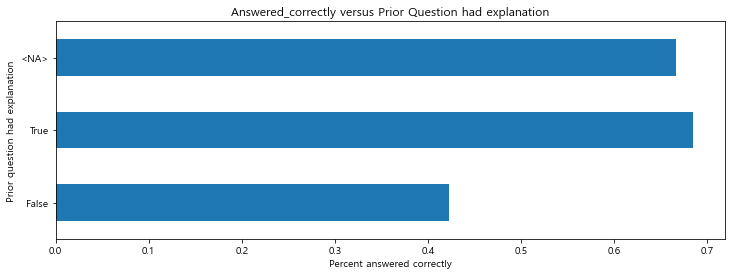

In [43]:
plt.figure(figsize=(12,4))
pqhe.plot.barh()
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.show()

---

In [227]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
9995,9995,2868187305,91216,1124,0,775,0,0,18000.0,True
9996,9996,2868272689,91216,810,0,776,0,1,18000.0,True
9997,9997,2868367298,91216,1245,0,777,0,1,17000.0,True
9998,9998,2868439137,91216,711,0,778,3,1,17000.0,True


In [228]:
train_que = train[train.content_type_id == 0]
train_lect = train[train.content_type_id == 1]
train_lect

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
89,89,653762,2746,6808,1,14,-1,-1,NaN,False
117,117,10183847,5382,16736,1,21,-1,-1,NaN,False
212,212,1424348597,5382,30207,1,104,-1,-1,NaN,False
216,216,1425557777,5382,18545,1,121,-1,-1,NaN,False
295,295,405813029,8623,10540,1,59,-1,-1,NaN,False
...,...,...,...,...,...,...,...,...,...,...
9903,9903,1990930333,91216,18091,1,683,-1,-1,NaN,False
9914,9914,1996114890,91216,13605,1,694,-1,-1,NaN,False
9928,9928,1997374102,91216,22034,1,708,-1,-1,NaN,False
9938,9938,1997886262,91216,7949,1,718,-1,-1,NaN,False


In [229]:
train_que = pd.merge(train_que, questions, left_on='content_id', right_on='question_id')
train_que

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5692,3,5,151
1,2385,4216576228,24418,5692,0,497,3,1,21000.0,True,5692,5692,3,5,151
2,8954,0,51285,5692,0,0,3,1,NaN,<NA>,5692,5692,3,5,151
3,9280,330907575,91216,5692,0,153,3,1,22000.0,True,5692,5692,3,5,151
4,1,56943,115,5716,0,2,2,1,37000.0,False,5716,5716,2,5,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9967,2159474235,91216,9843,0,746,2,1,7000.0,True,9843,9843,2,5,73
9759,9970,2159603640,91216,3622,0,749,2,1,19000.0,True,3622,3622,2,5,73
9760,9971,2159665671,91216,8190,0,750,3,0,14000.0,True,8190,8190,0,5,96
9761,9983,2835932406,91216,8848,0,762,1,1,10000.0,True,8848,8848,1,5,96


In [230]:
train_lect = pd.merge(train_lect, lectures, left_on='content_id', right_on='lecture_id')
train_lect

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,part,type_of
0,89,653762,2746,6808,1,14,-1,-1,NaN,False,6808,129,2,intention
1,2009,1623661788,24418,6808,1,121,-1,-1,NaN,False,6808,129,2,intention
2,9508,600004996,91216,6808,1,312,-1,-1,NaN,False,6808,129,2,intention
3,117,10183847,5382,16736,1,21,-1,-1,NaN,False,16736,40,1,concept
4,212,1424348597,5382,30207,1,104,-1,-1,NaN,False,30207,43,5,concept
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,9564,889592517,91216,28621,1,369,-1,-1,NaN,False,28621,175,5,concept
233,9734,1664021603,91216,2918,1,514,-1,-1,NaN,False,2918,78,5,concept
234,9790,1810915327,91216,27264,1,569,-1,-1,NaN,False,27264,34,5,solving question
235,9865,1977479330,91216,13471,1,645,-1,-1,NaN,False,13471,47,5,solving question


In [231]:
train1 = pd.concat([train_que, train_lect])
train1 = train1.drop(['question_id', 'lecture_id', 'bundle_id'], axis=1)

In [232]:
train1 = train1.sort_values(by=['row_id']).reset_index(drop=True)
# train1.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True, inplace=True)
train1

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,tag,type_of
0,0,0,115,5692,0,1,3,1,NaN,<NA>,3.0,5,151,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False,2.0,5,168,NaN,NaN
2,2,118363,115,128,0,0,0,1,55000.0,False,0.0,1,131 149 92,NaN,NaN
3,3,131167,115,7860,0,3,0,1,19000.0,False,0.0,1,131 104 81,NaN,NaN
4,4,137965,115,7922,0,4,1,1,11000.0,False,1.0,1,131 149 92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,2868187305,91216,1124,0,775,0,0,18000.0,True,3.0,2,138 41 81 92,NaN,NaN
9996,9996,2868272689,91216,810,0,776,0,1,18000.0,True,0.0,2,90 100 162 92 102,NaN,NaN
9997,9997,2868367298,91216,1245,0,777,0,1,17000.0,True,0.0,2,148 32 38 92,NaN,NaN
9998,9998,2868439137,91216,711,0,778,3,1,17000.0,True,3.0,2,129 143 30 38 92,NaN,NaN


In [107]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     9742 non-null   float64
 9   prior_question_had_explanation  9979 non-null   boolean
 10  bundle_id                       9763 non-null   float64
 11  correct_answer                  9763 non-null   float64
 12  part                            1

In [46]:
# lecture_id는 content_type_id가 1일때 content_id의 외래키
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [47]:
# question_id는 content_type_id가 0일때 content_id의 외래키
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [135]:
train1.correct_answer.unique()

array([ 3.,  2.,  0.,  1., nan])

In [145]:
train1.correct_answer.isna().sum()

237

In [158]:
train1['correct_answer'] = train1['correct_answer'].replace(np.nan, -1)

In [159]:
train1.correct_answer.unique()

array([ 3.,  2.,  0.,  1., -1.])

In [225]:
train1.astype({
    'correct_answer':int
})

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,tag,type_of
0,0,0,115,5692,0,1,3,1,0.0,False,3,5,151,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False,2,5,168,NaN,NaN
2,2,118363,115,128,0,0,0,1,55000.0,False,0,1,131 149 92,NaN,NaN
3,3,131167,115,7860,0,3,0,1,19000.0,False,0,1,131 104 81,NaN,NaN
4,4,137965,115,7922,0,4,1,1,11000.0,False,1,1,131 149 92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,2868187305,91216,1124,0,775,0,0,18000.0,True,3,2,138 41 81 92,NaN,NaN
9996,9996,2868272689,91216,810,0,776,0,1,18000.0,True,0,2,90 100 162 92 102,NaN,NaN
9997,9997,2868367298,91216,1245,0,777,0,1,17000.0,True,0,2,148 32 38 92,NaN,NaN
9998,9998,2868439137,91216,711,0,778,3,1,17000.0,True,3,2,129 143 30 38 92,NaN,NaN


In [273]:
train1[train.answered_correctly != -1].groupby(['content_type_id', 'user_id']).answered_correctly.mean()

content_type_id  user_id
0                115        0.695652
                 124        0.233333
                 2746       0.578947
                 5382       0.672000
                 8623       0.642202
                 8701       0.588235
                 12741      0.573585
                 13134      0.706356
                 24418      0.690275
                 24600      0.340000
                 32421      0.466667
                 40828      0.630435
                 44331      0.587629
                 45001      0.233333
                 46886      0.613636
                 50132      0.621622
                 51285      0.545455
                 53842      0.233333
                 81002      0.529412
                 81429      0.466667
                 91216      0.671397
Name: answered_correctly, dtype: float64

In [274]:
# train1.to_csv('train1.csv')

---

<AxesSubplot:>

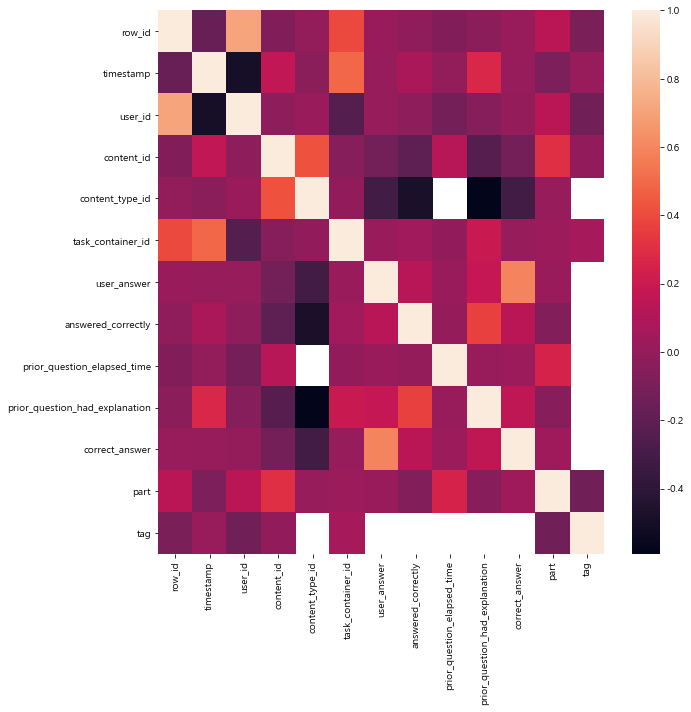

In [164]:
plt.figure(figsize=(10,10))
sns.heatmap(train1.corr())

<AxesSubplot:>

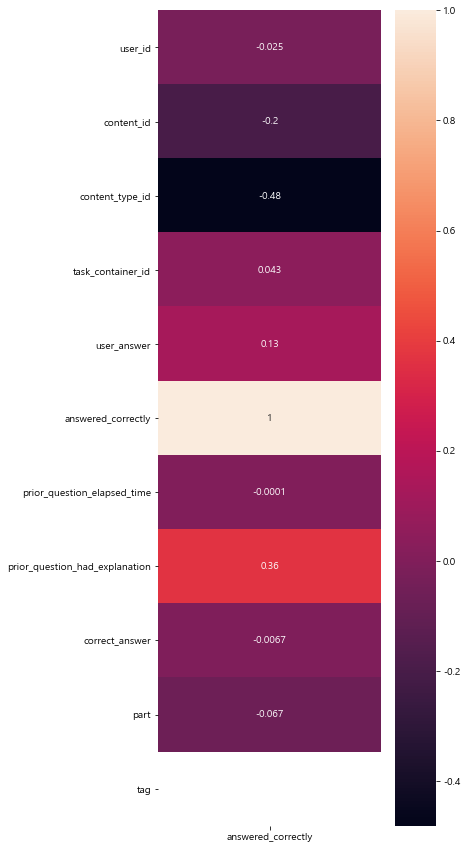

In [237]:
fig = plt.figure(figsize=(5,15))
sns.heatmap(train1.drop(['row_id', 'timestamp'], axis=1).corr()[['answered_correctly']], annot=True)

<AxesSubplot:>

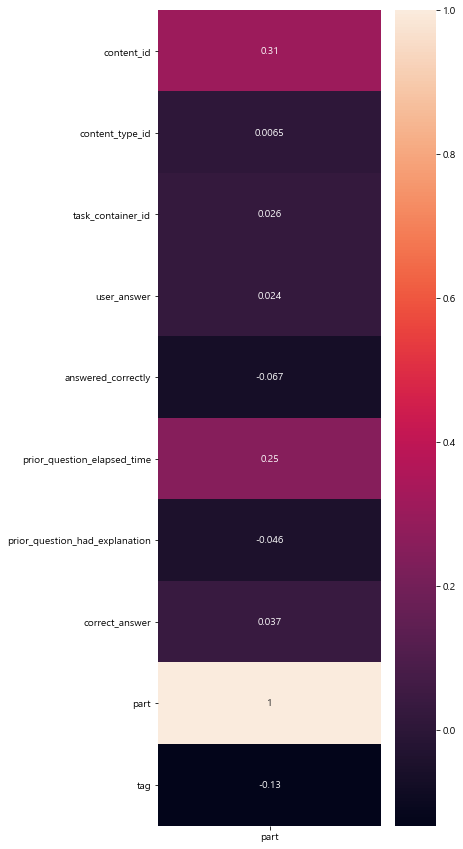

In [173]:
fig = plt.figure(figsize=(5,15))
sns.heatmap(train1.drop(['row_id', 'user_id', 'timestamp'], axis=1).corr()[['part']], annot=True)

---

## 데이터 모델 검증

In [251]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     9742 non-null   float64
 9   prior_question_had_explanation  9979 non-null   boolean
 10  correct_answer                  9763 non-null   float64
 11  part                            10000 non-null  int64  
 12  tags                            9

In [252]:
train1.prior_question_elapsed_time.fillna(0, inplace=True)
train1.prior_question_had_explanation.fillna(False, inplace=True)

In [253]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10000 non-null  int64  
 1   timestamp                       10000 non-null  int64  
 2   user_id                         10000 non-null  int64  
 3   content_id                      10000 non-null  int64  
 4   content_type_id                 10000 non-null  int64  
 5   task_container_id               10000 non-null  int64  
 6   user_answer                     10000 non-null  int64  
 7   answered_correctly              10000 non-null  int64  
 8   prior_question_elapsed_time     10000 non-null  float64
 9   prior_question_had_explanation  10000 non-null  boolean
 10  correct_answer                  9763 non-null   float64
 11  part                            10000 non-null  int64  
 12  tags                            9

In [254]:
from sklearn.preprocessing import StandardScaler

In [255]:
train1.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'correct_answer', 'part', 'tags', 'tag', 'type_of'],
      dtype='object')

In [256]:
X_num = train1[['user_id', 'content_id', 'content_type_id',
        'task_container_id', 'user_answer', 'prior_question_elapsed_time',
        ]]
X_cat = train1[['part','prior_question_had_explanation']]

scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)

X = pd.concat([X_scaled, X_cat], axis=1)
y = train1['answered_correctly']

In [257]:
X

,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,part,prior_question_had_explanation
0,-1.375735,0.090197,-0.155805,-1.124163,1.354944,-1.703137,5,False
1,-1.375735,0.095836,-0.155805,-1.123514,0.521748,1.225838,5,False
2,-1.375735,-1.217016,-0.155805,-1.124812,-1.144645,2.650745,1,False
3,-1.375735,0.599550,-0.155805,-1.122865,-1.144645,-0.199069,1,False
4,-1.375735,0.614116,-0.155805,-1.122216,-0.311449,-0.832361,1,False
...,...,...,...,...,...,...,...,...
9995,2.836041,-0.983014,-0.155805,-0.621805,-1.144645,-0.278230,2,True
9996,2.836041,-1.056786,-0.155805,-0.621156,-1.144645,-0.278230,2,True
9997,2.836041,-0.954586,-0.155805,-0.620507,-1.144645,-0.357392,2,True
9998,2.836041,-1.080045,-0.155805,-0.619858,1.354944,-0.357392,2,True


In [258]:
from sklearn.model_selection import train_test_split

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [249]:
from sklearn.linear_model import LogisticRegression

In [260]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [261]:
from sklearn.metrics import classification_report

In [262]:
pred = model_lr.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        58
           0       0.56      0.07      0.13       960
           1       0.68      0.97      0.80      1982

    accuracy                           0.69      3000
   macro avg       0.75      0.68      0.64      3000
weighted avg       0.65      0.69      0.59      3000



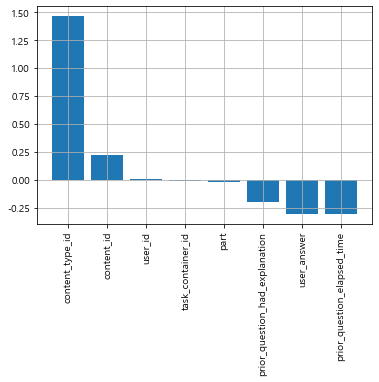

In [263]:
# Logistic Regression 모델의 coef_ 속성을 plot하기
model_coef = pd.DataFrame(data=model_lr.coef_[0], index=X.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.bar(model_coef.index, model_coef['Model Coefficient'])
plt.xticks(rotation=90)
plt.grid()
plt.show()
